<a href="https://colab.research.google.com/github/Uditsingh7/Deep_Learning_Projects/blob/main/Udit_Image_Classification_Pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Transfer learning

In [3]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: uditsinghthakur
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 1.34GB/s]

In [19]:
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from torchvision import models # PyTorch models
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac


In [5]:
train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")

data_df = pd.concat([train_df, val_df], ignore_index=True)

data_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + data_df["image:FILE"]

print("Data shape is: ", data_df.shape)
print()
data_df.head()

Data shape is:  (1167, 2)



,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


In [6]:
train_df['category'].value_counts()

,count
category,
2,348
1,345
0,341


In [7]:
print("Classes are: ")
print(data_df["category"].unique())
print()
print("Classes ditrubution are: ")
print(data_df["category"].value_counts())


Classes are: 
[0 1 2]

Classes ditrubution are: 
category
2    393
1    389
0    385
Name: count, dtype: int64


In [8]:
# Data split
train=data_df.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data_df.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%


In [18]:
# Preprocessing Objects


label_encoder = LabelEncoder() # Encode the string classes to numeric

transform = transforms.Compose([
    transforms.Resize((128, 128)), # One size for all images
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float), # The values are in floating point numbers
    ]) # Transform all images into one clear format (preprocess all images to same properties)


In [10]:
# Custom Dataset Class

# Custom dataset class for image classification using PyTorch's Dataset abstraction
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): Contains image file paths and category labels.
            transform (callable, optional): Transformations (e.g., resizing, normalization) applied to each image.
        """
        self.dataframe = dataframe
        self.transform = transform

        # Convert string category labels into numerical labels using LabelEncoder.
        # fit_transform() both learns label mapping AND transforms in one step.
        # torch.tensor(...) creates a tensor from these labels.
        # .to(device) ensures they are stored on GPU (or CPU depending on device).
        self.labels = torch.tensor(
            label_encoder.fit_transform(dataframe['category'])
        ).to(device)

    def __len__(self):
        """
        Returns:
            int: Total number of samples in the dataset.
        """
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (image_tensor, label_tensor)
        """
        # 1. Fetch the image file path from the dataframe using iloc.
        img_path = self.dataframe.iloc[idx, 0]

        # 2. Get the corresponding label from the pre-encoded label tensor.
        label = self.labels[idx]

        # 3. Open the image in RGB mode to ensure consistent 3-channel input.
        image = Image.open(img_path).convert('RGB')

        # 4. Apply transformations (e.g., resize, crop, to_tensor, normalize).
        # Dividing by 255 scales pixel values from [0,255] → [0,1],
        # which helps models converge faster when not using built-in ToTensor() normalization.
        if self.transform:
            image = (self.transform(image) / 255).to(device)

        # 5. Return the transformed image tensor and its label.
        return image, label


In [12]:
# Creating the training dataset object using our custom dataset class
# WHY:
# - This wraps our raw 'train' DataFrame into a PyTorch Dataset so DataLoader can iterate over it in batches.
# - transform=transform applies preprocessing (resize, normalization, augmentation) to each image on-the-fly.
# - Keeps memory usage efficient because images are processed only when fetched.
train_dataset = CustomImageDataset(dataframe=train, transform=transform)

# Creating the test dataset object using our custom dataset class
# WHY:
# - Same as above but for the test/validation set.
# - Ensures test data goes through the same preprocessing pipeline as training (important for consistent feature distribution).
# - No data augmentation here usually — but if the same 'transform' is passed, it must be checked whether it contains augmentations
#   because augmenting test data can give misleading evaluation results.
test_dataset = CustomImageDataset(dataframe=test, transform=transform)


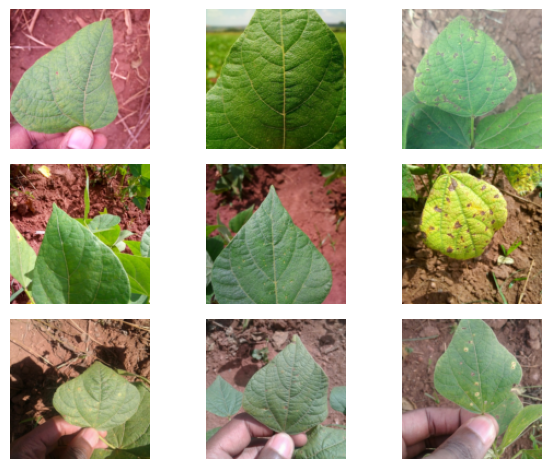

In [13]:
# Number of rows and columns for the image grid
n_rows = 3
n_cols = 3

# Create a figure and a grid of subplots (n_rows x n_cols)
# plt.subplots returns:
#   f -> Figure object (the overall canvas)
#   axarr -> 2D array of Axes objects (individual plots)
# This is useful for visualizing multiple samples at once in a clean layout.
f, axarr = plt.subplots(n_rows, n_cols)

# Loop over each subplot position (row, col)
for row in range(n_rows):
    for col in range(n_cols):

        # Randomly select an index from the training dataset
        # train_dataset.__len__() returns the total number of samples
        # np.random.randint(...) picks a random sample index.
        # train_dataset[idx] returns a tuple: (image_tensor, label)
        # [0] means we only take the image, ignoring the label for now
        # .cpu() ensures the tensor is on the CPU (matplotlib can't plot GPU tensors)
        image = train_dataset[np.random.randint(0, train_dataset.__len__())][0].cpu()

        # Display the image:
        # image*255 -> Convert normalized [0,1] values back to [0,255] range
        # .squeeze() -> Remove any extra single-dimension axes (e.g., (1,H,W) → (H,W))
        # .permute(1,2,0) -> Rearrange tensor from (C,H,W) → (H,W,C) for plotting
        axarr[row, col].imshow((image*255).squeeze().permute(1, 2, 0))

        # Remove axis ticks and labels for a cleaner look
        axarr[row, col].axis('off')

# Adjust subplot spacing so images don't overlap
plt.tight_layout()

# Render the figure
plt.show()


In [14]:
#hyperparameters



In [23]:
# Learning rate — controls how big the weight updates are in each step of gradient descent.
# Too high → unstable training, might skip optimal minima.
# Too low → very slow convergence, might get stuck in local minima.
LR = 1e-3

# Batch size — number of samples processed before updating the model’s parameters.
# Smaller batch sizes → more noisy gradient estimates but can help generalization.
# Larger batch sizes → smoother gradients but require more memory.
BATCH_SIZE = 4

# Number of epochs — 1 epoch = 1 full pass through the training dataset.
# More epochs → more opportunities for learning, but too many can lead to overfitting.
EPOCHS = 15


In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [26]:
# Load the pre-trained GoogleNet model with default ImageNet weights.
# Using pre-trained weights allows transfer learning — the model starts with already learned
# low- and mid-level features (edges, textures, shapes), which speeds up convergence and
# requires less data than training from scratch.
googlenet_model = models.googlenet(weights='DEFAULT')

# By default, many transfer learning workflows freeze earlier layers to keep learned features
# intact and only train the final layers.
# Here, we explicitly set 'requires_grad = True' for *all* parameters so every layer will
# be fine-tuned on our new dataset.
# This can improve performance if our target dataset is quite different from ImageNet,
# but it also increases risk of overfitting and requires more computation.
for param in googlenet_model.parameters():
    param.requires_grad = True


In [27]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [28]:
num_classes = len(data_df["category"].unique())
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [29]:
# Determine the number of unique output classes from the dataset
# We need this because the final layer of the network must output exactly one score per class.
num_classes = len(data_df["category"].unique())

# Replace the original GoogLeNet final classification layer with a new one matching our task's number of classes
# googlenet_model.fc.in_features → the number of input features coming into the final FC layer
# torch.nn.Linear(..., num_classes) → new FC layer mapping those features to our required number of class logits
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)

# Move the updated model to the training device (GPU if available, otherwise CPU)
# This ensures both data and model are on the same device for faster computation and no device mismatch errors.
googlenet_model.to(device)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [30]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(googlenet_model.parameters(), lr=LR) # Adam optimizer

In [31]:
# Lists to store loss and accuracy values after each epoch (for plotting/tracking learning progress)
total_loss_train_plot = []
total_acc_train_plot = []

# Loop over the number of training epochs
for epoch in range(EPOCHS):
    # Reset accumulators for this epoch
    total_acc_train = 0    # total number of correct predictions in this epoch
    total_loss_train = 0   # total training loss accumulated in this epoch

    # Iterate over batches from the training DataLoader
    for (inputs, labels) in train_loader:
        # Step 1: Reset gradients from the previous iteration
        # Without this, PyTorch would accumulate gradients and training would diverge
        optimizer.zero_grad()

        # Step 2: Forward pass
        # Pass the inputs through the model to get predictions
        outputs = googlenet_model(inputs)

        # Step 3: Compute the loss
        # Loss measures how far our predictions are from the true labels
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()  # store batch loss (converted to Python float)

        # Step 4: Backpropagation
        # Compute gradients of the loss w.r.t. model parameters
        train_loss.backward()

        # Step 5: Calculate batch accuracy
        # torch.argmax gets predicted class index; compare with ground truth labels
        train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_train += train_acc  # accumulate total correct predictions

        # Step 6: Update weights
        # optimizer.step() uses stored gradients to perform a parameter update
        optimizer.step()

    # Store average loss and accuracy for this epoch
    # Loss is divided by 1000 here (possibly batch count scaling; adjust if needed)
    total_loss_train_plot.append(round(total_loss_train / 1000, 4))

    # Accuracy: total correct predictions / total samples * 100 (percentage)
    total_acc_train_plot.append(
        round(total_acc_train / len(train_dataset) * 100, 4)
    )

    # Print progress for the epoch (good for quick debugging and monitoring convergence)
    print(f"Epoch {epoch+1}/{EPOCHS}, "
          f"Train Loss: {round(total_loss_train / 100, 4)} "
          f"Train Accuracy {round(total_acc_train / len(train_dataset) * 100, 4)}%")
    print()


Epoch 1/15, Train Loss: 1.964 Train Accuracy 53.366%

Epoch 2/15, Train Loss: 1.7214 Train Accuracy 61.8115%

Epoch 3/15, Train Loss: 1.6784 Train Accuracy 63.8923%

Epoch 4/15, Train Loss: 1.5492 Train Accuracy 66.4627%

Epoch 5/15, Train Loss: 1.4489 Train Accuracy 70.1346%

Epoch 6/15, Train Loss: 1.487 Train Accuracy 70.9914%

Epoch 7/15, Train Loss: 1.4772 Train Accuracy 68.7882%

Epoch 8/15, Train Loss: 1.2811 Train Accuracy 74.2962%

Epoch 9/15, Train Loss: 1.1876 Train Accuracy 76.1322%

Epoch 10/15, Train Loss: 1.0214 Train Accuracy 80.7834%

Epoch 11/15, Train Loss: 1.0645 Train Accuracy 79.1922%

Epoch 12/15, Train Loss: 1.0745 Train Accuracy 80.1714%

Epoch 13/15, Train Loss: 0.9507 Train Accuracy 83.5985%

Epoch 14/15, Train Loss: 0.9829 Train Accuracy 81.5177%

Epoch 15/15, Train Loss: 0.9793 Train Accuracy 81.7625%



In [32]:
# Disable gradient calculations to reduce memory usage and speed up computations
# since we are only doing inference/testing here, no backpropagation needed.
with torch.no_grad():
    # Initialize variables to accumulate total loss and accuracy over the test set
    total_loss_test = 0  # (Though not used here, can be kept if loss needed later)
    total_acc_test = 0   # To keep track of total correct predictions

    # Loop over batches of input data and their labels from the test data loader
    for indx, (input, labels) in enumerate(test_loader):

        # Forward pass: get predictions from the model for the input batch
        prediction = googlenet_model(input)

        # Calculate number of correct predictions in this batch
        # torch.argmax(prediction, axis=1) gets predicted class per sample
        # Compare with true labels, then sum correct predictions
        acc = (torch.argmax(prediction, axis=1) == labels).sum().item()

        # Accumulate total correct predictions across all batches
        total_acc_test += acc

# Calculate overall accuracy as (correct predictions / total samples) * 100
# Using test_dataset.__len__() to get total number of test samples
print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")


Accuracy Score is: 76.57%


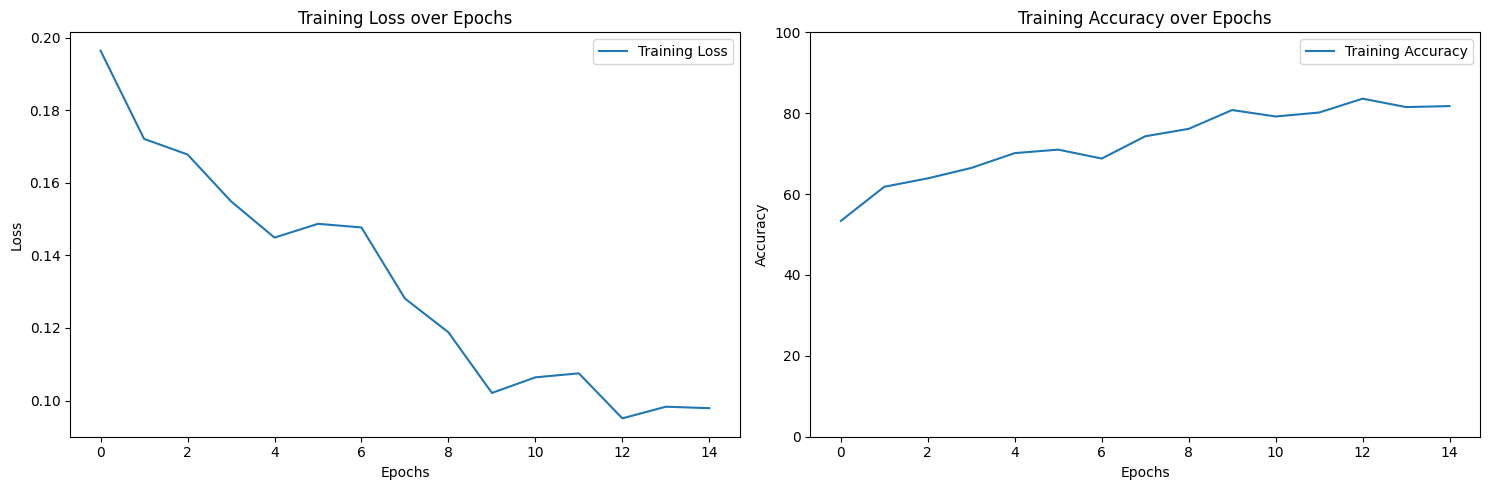

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()